In [78]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: roicat
python version: 3.11.3


In [84]:
import pprint
from pathlib import Path
import re
from functools import partial
import gc

import natsort
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.io as pio
import plotly.graph_objects as go
from tqdm import tqdm

In [85]:
%load_ext autoreload
%autoreload 2
import bnpm
import bnpm.server
import bnpm.plotting_helpers
import bnpm.file_helpers
import bnpm.path_helpers
import bnpm.indexing
import bnpm.timeSeries
import bnpm.decomposition
import bnpm.similarity

import bnpm.parallel_helpers
import bnpm.ca2p_preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import itertools
import datetime

import scipy.io
import pandas as pd
import numpy as np
import matplotlib as mpl

import torch

In [5]:
## mouse_0322R
mouse = 'mouse_0322R'
cage = 'cage_0322'


dates_toUse = [
#     '20230419',
#     '20230420',
#     '20230421',
#     '20230422',
#     '20230423',
#     '20230424',
#     '20230425',
#     '20230426',
#     '20230427',
#     '20230428',
#     '20230429',
#     '20230430',
#     '20230501',
    
    '20230502',
    '20230503',
    '20230504',
    '20230505',
#     '20230506',
#     '20230507',
#     '20230508',
#     '20230509',
#     '20230511',
#     '20230512',
#     '20230513',
#     '20230514',
#     '20230515',
#     '20230516',
#     '20230517',
#     '20230518',
#     '20230519',
#     '20230520',
    
#     '20230521',
#     '20230522',
#     '20230523',
#     '20230524',
#     '20230525',
#     '20230526',
#     '20230527',
#     '20230528',
#     '20230529',
#     '20230530',
#     '20230531',
]

In [6]:
# ## mouse_0322N
# mouse = 'mouse_0322N'
# cage = 'cage_0322'

# dates_toUse = [
#     '20230430',
#     '20230501',
#     '20230502',
#     '20230503',
#     '20230504',
#     '20230505',
#     '20230506',
#     '20230507',
#     '20230508',
#     '20230509',
# ]

In [129]:
## mouse_0403N
mouse = 'mouse_0403L'
cage = 'cage_0403'

dates_toUse = [
    '20230702',
    '20230703',
    '20230705',
    '20230706',
    '20230708',
    '20230709',
    '20230710',
    '20230711',
    '20230712',
    '20230713',
    '20230714',
    '20230715',
    '20230716',
    '20230717',
    '20230718',
]

In [132]:
Fs = 30

In [133]:
!ls /media/gyuheo/storage_1/data_analysis/

mouse_0322N  mouse_0322R  mouse_0403L  test.npy


In [130]:
dir_save_data = f'/media/gyuheo/storage_1/data_analysis/{mouse}'

In [131]:
fig_save = f'/media/gyuheo/storage_1/data_analysis/{mouse}'

# Functions

In [187]:
pio.renderers.default='notebook'

def plotly_imshow(image, cmap='Viridis', zmin=None, zmax=None):
    
    # Create the figure
    # fig = go.Figure(data=go.Heatmap(z=image, colorscale='Viridis', zmin=-1, zmax=1))
    fig = go.Figure(data=go.Heatmap(z=image, colorscale=cmap, zmin=zmin, zmax=zmax))

    # Flip y-axis
    fig.update_yaxes(autorange="reversed")

    # Adjust aspect ratio to make the plot square and define the output size
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
        margin=dict(
            l=50,  # left margin
            r=50,  # right margin
            b=100,  # bottom margin
            t=100,  # top margin
            pad=10
        )
    )

    return fig

In [188]:
def center_mean(X, axis=0, verbose=True):
    """
    Given T * N matrix, where T is the number of sample and N is the number of neurons, mean-center along T axis.
    Flexibly modifyable by changing axis parameter.
    
    args:
        X (np.ndarray): num.sample * num.feature shape matrix.
        axis (int): mean-centering happens along this axis.
        
    Return:
        mean-centered matrix
    """
    
    X_mean = np.nanmean(X, axis=axis, keepdims=True)
    
    if verbose:
        print(f"Given matrix shape: {X.shape}")
        print(f"Subtract matrix shape: {X_mean.shape}")
    
    return X - X_mean

In [189]:
def compute_average_angle(X1, X2, mean_center = False, verbose = False):
    """
    X1, X2 shapes T * N matrices, where T is the number of sample and N is the number of neurons.
    
    args:
        X1, X2 (np.ndarray): num.sample * num.feature shape matrix.
        mean_center (bool): If True, apply mean-centering transformation
    
    Return:
        angles_mean (float): average angular difference between features. [0, np.pi]
    """
    if mean_center:
        X1 = center_mean(X1, verbose=verbose)
        X2 = center_mean(X2, verbose=verbose)

    cossim = np.sum((X1 * X2) / (np.linalg.norm(X1, axis=1, keepdims=True) * np.linalg.norm(X2, axis=1, keepdims=True)), axis=1)

    ## Change to angle (metric space) and take the mean of angles
    cossim = np.clip(cossim, -1, 1) # This line is necessary to prevent error
    angles = np.arccos(cossim)
    angles_mean = np.mean(angles)
    
    ## Return the average angle
    return angles_mean

In [190]:
def fill_symmetric(input_list):
    """
    Given a list of pairwise distance, make a (symmetric) similarity / distance matrix
    """
    n = int((-1 + np.sqrt(1 + 8*len(input_list))) / 2)
    matrix = np.zeros((n, n))
    
    indices = np.triu_indices(n)
    matrix[indices] = input_list
    matrix = matrix + matrix.T - np.diag(np.diag(matrix))

    return matrix

# Import Data from local

### logger and expParams

make lists of logger dicts and expParams dicts

In [87]:
paths_local_logger = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/gyuheo/storage_1/data_analysis/{mouse}/loggers/',
    reMatch='logger.mat',
    depth=2
)
paths_local_logger = [p for p in paths_local_logger if Path(p).parent.name in dates_toUse]
display(paths_local_logger)


load_logger = lambda path: {Path(path).parent.name: scipy.io.loadmat(file_name=path, simplify_cells=True)['logger']}

logger_objs = {}
[logger_objs.update(load_logger(path)) for path in tqdm(paths_local_logger)];

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230702/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230703/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230705/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230706/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230708/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230709/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230710/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230711/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230712/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230713/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230714/logger.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230715/logger.mat',
 '/media/gyuheo/

100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  7.56it/s]


In [88]:
paths_local_dFoFROIs = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/gyuheo/storage_1/data_analysis/{mouse}/loggers/',
    reMatch='logger_dFoFROIs.mat',
    depth=2
)
paths_local_dFoFROIs = [p for p in paths_local_dFoFROIs if Path(p).parent.name in dates_toUse]
display(paths_local_dFoFROIs)

load_dFoFROIs = lambda path: {Path(path).parent.name: scipy.io.loadmat(file_name=path, simplify_cells=True)['logger_dFoFROIs']}

dFoFROIs_objs = {}
[dFoFROIs_objs.update(load_dFoFROIs(path)) for path in tqdm(paths_local_dFoFROIs)];
# bnpm.parallel_helpers.map_parallel(lambda p: loggerValsAligned_objs.update(load_loggerValsAligned(p)), paths_local_loggerValsAligned, method='serial');

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230702/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230703/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230705/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230706/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230708/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230709/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230710/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230711/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230712/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230713/logger_dFoFROIs.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230714/logger_dFoFROIs.mat',

100%|███████████████████████████████████████████| 15/15 [00:22<00:00,  1.48s/it]


In [89]:
paths_local_expParams = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/gyuheo/storage_1/data_analysis/{mouse}/loggers/',
    reMatch='expParams.mat',
    depth=2
)
paths_local_expParams = [p for p in paths_local_expParams if Path(p).parent.name in dates_toUse]
display(paths_local_expParams)

load_expParams = lambda path: {Path(path).parent.name: bnpm.file_helpers.matlab_load(filepath=path, simplify_cells=True)['expParams']}

expParams_objs = {}
[expParams_objs.update(load_expParams(path)) for path in tqdm(paths_local_expParams)];

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230702/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230703/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230705/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230706/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230708/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230709/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230710/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230711/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230712/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230713/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230714/expParams.mat',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/loggers/20230

100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.49it/s]


## Import F and Fneu

In [90]:
paths_local_expParams = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/gyuheo/storage_1/data_analysis/{mouse}/statFiles/',
    reMatch='F.npy',
    depth=2
)
paths_local_F = [p for p in paths_local_expParams if Path(p).parent.name in dates_toUse]
display(paths_local_F)

F_objs = {}
def loader(path):
    F_objs.update({Path(path).parent.name: np.load(path)})
[F_objs.update({Path(path).parent.name: np.load(path)}) for path in tqdm(paths_local_F)];
# bnpm.parallel_helpers.map_parallel(loader, paths_local_F, method='mpire');

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230702/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230703/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230705/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230706/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230708/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230709/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230710/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230711/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230712/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230713/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230714/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230715/F.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/

100%|███████████████████████████████████████████| 15/15 [01:46<00:00,  7.08s/it]


In [91]:
paths_local_expParams = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/gyuheo/storage_1/data_analysis/{mouse}/statFiles/',
    reMatch='Fneu.npy',
    depth=2
)
paths_local_Fneu = [p for p in paths_local_expParams if Path(p).parent.name in dates_toUse]
display(paths_local_Fneu)


Fneu_objs = {}
def loader(path):
    Fneu_objs.update({Path(path).parent.name: np.load(path)})
[Fneu_objs.update({Path(path).parent.name: np.load(path)}) for path in tqdm(paths_local_Fneu)];
# bnpm.parallel_helpers.map_parallel(loader, paths_local_Fneu, method='multiprocessing');

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230702/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230703/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230705/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230706/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230708/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230709/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230710/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230711/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230712/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230713/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230714/Fneu.npy',
 '/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles/20230715/Fneu.npy',
 '/media/gyuheo/

100%|███████████████████████████████████████████| 15/15 [01:45<00:00,  7.06s/it]


## Import ROICaT

In [134]:
dir_save_data

'/media/gyuheo/storage_1/data_analysis/mouse_0403L'

In [135]:
path_roicat = bnpm.path_helpers.find_paths(dir_save_data, reMatch='ROICaT')
# path_roicat = bnpm.path_helpers.find_paths(dir_save_data, reMatch='roicat')[0]
display(path_roicat)
roicat_out = bnpm.file_helpers.pickle_load(path_roicat[0])
display(path_roicat[0])

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles.ROICaT.tracking.results_to0718.pkl']

'/media/gyuheo/storage_1/data_analysis/mouse_0403L/statFiles.ROICaT.tracking.results_to0718.pkl'

## Import iscell and tqm

In [106]:
# iscell_tqm_title = 'iscell'
iscell_tqm_title = 'trace_quality'

path_iscell = bnpm.path_helpers.find_paths(dir_save_data, reMatch=iscell_tqm_title, depth=3)
print(path_iscell)

iscell = np.load(path_iscell[0], allow_pickle=True)
display(path_iscell[0])

iscell['iscell_classifier_matching_tqm'] = [iscell['iscell_tqm']]

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/day0_analysis/trace_quality.pkl']


'/media/gyuheo/storage_1/data_analysis/mouse_0403L/day0_analysis/trace_quality.pkl'

In [107]:
len(iscell['iscell_classifier_matching_tqm'][0])

3164

In [96]:
test

['/media/gyuheo/storage_1/data_analysis/mouse_0403L/day0_analysis/trace_quality.pkl']

In [92]:
test = bnpm.path_helpers.find_paths(dir_save_data, reMatch='trace_quality', depth=3)

In [99]:
import pickle
with open(test[0], 'rb') as handle:
    test_load = pickle.load(handle)

In [105]:
test_load['iscell_tqm'][0]

True

In [104]:
F_objs['20230703'].shape

(3164, 108000)

## import spike_prob

# Analysis

make dataframes for each logger using the loggerNames field from expParams

In [109]:
logger_dfs = {
    date: {
        key_outer: pd.DataFrame(
            data=logger_objs[date][key_outer][:, :len(expParams_objs[date]['loggerNames'][key_outer])], 
            columns=expParams_objs[date]['loggerNames'][key_outer],
        ) for key_outer in expParams_objs[date]['loggerNames'].keys()
    } for date in expParams_objs.keys()
}

In [110]:
def get_frames_111_success(logger):
    frames_trialEnds   = logger['trials']['frameNum_trialEnd'].to_numpy() - 1
    frames_trialStarts = logger['trials']['frameNum_trialStart'].to_numpy() - 1

# #     mouse_B
#     frames_trialEnds   = logger['trials']['counter_frameNum_trialEnd'].to_numpy() - 1
#     frames_trialStarts = logger['trials']['counter_frameNum_trialStart'].to_numpy() - 1
    
#     frames_trialEnds = np.where(np.diff(logger['timeSeries']['CE_trial'].to_numpy(), append=0) < -0.5)[0]

    type_111_success = np.nan_to_num((logger['trials']['trialType_cursorOn'] * logger['trials']['trialType_feedbackLinked'] * logger['trials']['trialType_rewardOn'] * logger['trials']['success_outcome']).to_numpy(), nan=0).astype(bool)
    framesEnd_111_success = frames_trialEnds[type_111_success]
    framesStart_111_success = frames_trialStarts[type_111_success]
    
#     print(framesStart_111_success)
        
    out = {
        'trialNum': logger['trials']['trialNum_trialStart'],
        'frames_start': framesStart_111_success,
        'frames_end': framesEnd_111_success,
        'duration': logger['trials']['frameNum_trialEnd'] - logger['trials']['frameNum_trialStart'],
        '111_duration': framesEnd_111_success - framesStart_111_success
    }
    
    return out

# trials_111_success = {date: get_frames_111_success(logger) for date, logger in loggerAligned_dfs.items()}
trials_111_success = {date: get_frames_111_success(logger) for date, logger in logger_dfs.items()}

In [111]:
trials_111_success

{'20230702': {'trialNum': 0      1.0
  1      2.0
  2      3.0
  3      4.0
  4      5.0
        ... 
  495    NaN
  496    NaN
  497    NaN
  498    NaN
  499    NaN
  Name: trialNum_trialStart, Length: 500, dtype: float64,
  'frames_start': array([], dtype=float64),
  'frames_end': array([], dtype=float64),
  'duration': 0      306.0
  1      599.0
  2      599.0
  3      192.0
  4      599.0
         ...  
  495      NaN
  496      NaN
  497      NaN
  498      NaN
  499      NaN
  Length: 500, dtype: float64,
  '111_duration': array([], dtype=float64)},
 '20230703': {'trialNum': 0      1.0
  1      2.0
  2      3.0
  3      4.0
  4      5.0
        ... 
  495    NaN
  496    NaN
  497    NaN
  498    NaN
  499    NaN
  Name: trialNum_trialStart, Length: 500, dtype: float64,
  'frames_start': array([], dtype=float64),
  'frames_end': array([], dtype=float64),
  'duration': 0      370.0
  1       61.0
  2      599.0
  3      200.0
  4      599.0
         ...  
  495      NaN
  496   

In [112]:
n_sessions = len(logger_dfs)

trials_duration_frame = []
trials_duration_nowTime = []
trials_success = []
trials_type_111 = []

for logger_df in logger_dfs.values():
    # pull out frames of start and end. -1 to account for matlab 1-indexing
    frame_start__idx_logger = logger_df['trials']['frameNum_trialStart'].to_numpy() - 1
    frame_end__idx_logger = logger_df['trials']['frameNum_trialEnd'].to_numpy() - 1   

# #     mouse_B
#     frame_start__idx_logger = logger_df['trials']['counter_frameNum_trialStart'].to_numpy() - 1
#     frame_end__idx_logger = logger_df['trials']['counter_frameNum_trialEnd'].to_numpy() - 1 
    
    
    
#     frame_start__idx_SI = bnpm.indexing.index_with_nans(
#         values=align['inds_align_logger2movie'],
#         indices=frame_start__idx_logger,
#     )
#     frame_end__idx_SI = bnpm.indexing.index_with_nans(
#         values=align['inds_align_logger2movie'],
#         indices=frame_end__idx_logger,
#     )
#     trials_duration_frame.append((frame_end__idx_SI - frame_start__idx_SI))
    
    ## pull out durations using time
    time_start__idx_logger = logger_df['trials']['time_now_trialStart'].to_numpy()
    time_end__idx_logger = logger_df['trials']['time_now_trialEnd'].to_numpy()
    trials_duration_nowTime.append((time_end__idx_logger - time_start__idx_logger))

    ## pull out whether the outcome was a success
    trials_success.append(logger_df['trials']['success_outcome'] == 1)
    
    ## pull out whether the trial type was a standard trial with feedback, reward, and cursor all one (1 1 1)
    trials_type_111.append((logger_df['trials']['trialType_cursorOn'] == 1) * (logger_df['trials']['trialType_feedbackLinked'] == 1) * (logger_df['trials']['trialType_rewardOn'] == 1))
    

In [113]:
trials_numSuccess__111 = [np.nansum(trials_success[ii][trials_type_111[ii]]) for ii in range(n_sessions)]

Text(0.5, 1.0, 'rewards total')

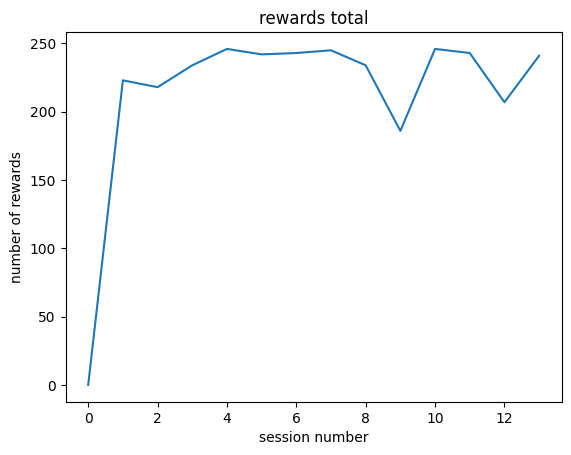

In [114]:
plt.figure()
plt.plot(trials_numSuccess__111[1:])
plt.xlabel('session number')
plt.ylabel('number of rewards');
plt.title('rewards total')

In [115]:
trials_duration_time__success_111 = [trials_duration_nowTime[sn][trials_success[sn] * trials_type_111[sn]] * 24*60*60 for sn in range(len(trials_duration_nowTime))]

edges = np.linspace(0,20, num=41, endpoint=True)
trials_durationHist_time__success_111 = np.array([np.histogram(t, bins=edges)[0] for t in trials_duration_time__success_111]).T

In [116]:
trials_durationHist_time__success_111.shape

(40, 15)

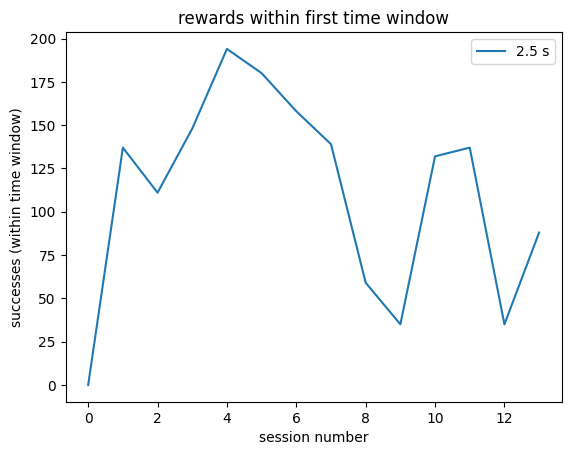

In [117]:
# ts = [1,2,5,10]
ts = [5]
plt.figure()
[plt.plot(trials_durationHist_time__success_111[:t,1:].sum(0)) for t in ts]
plt.xlabel('session number')
plt.ylabel('successes (within time window)')
plt.title('rewards within first time window')
plt.legend([f'{t*0.5} s' for t in ts])

## Align data with ROICaT outputs

In [136]:
len(roicat_out['clusters']['labels_bySession'])

16

In [137]:
roicat_out['clusters']['labels_bySession'][0].shape

(3019,)

In [138]:
# ucids_decoderVector = roicat_out['clusters']['labels_bySession'][0][iscell]
ucids_decoderVector = roicat_out['clusters']['labels_bySession'][1][iscell['iscell_classifier_matching_tqm'][0]]

In [139]:
ucids_byDate = {re.search('\d{8}', roicat_out['input_data']['paths_stat'][ii]).group(): roicat_out['clusters']['labels_bySession'][ii] for ii in range(len(roicat_out['clusters']['labels_bySession']))}

In [140]:
## find indices in each session that match with UCID in the ucids_decoderVector array
### the (val>=0) bit is to make sure the -1 values are excluded

idx_matching_decoderVector_raw = {date: [np.where((ucids_byDate[date] == val) * (val>=0))[0] for val in ucids_decoderVector] for date in tqdm(ucids_byDate.keys())};

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 80.90it/s]


In [141]:
## turn into list of arrays
idx_matching_decoderVector = {date: np.array([val[0] if len(val)==1 else -1 for val in arr], dtype=np.int64) for date, arr in idx_matching_decoderVector_raw.items()}

In [142]:
## check to make sure there aren't any duplicates
assert all([all([len(idx)<=1 for idx in idx_raw]) for idx_raw in idx_matching_decoderVector_raw])

In [143]:
rois_matched = [rois[idx] for rois,idx in zip(roicat_out['ROIs']['ROIs_aligned'], idx_matching_decoderVector.values())]

In [145]:
rois_matched[5].shape

(2151, 524288)

In [148]:
dir_save_data

'/media/gyuheo/storage_1/data_analysis/mouse_0403L'

In [154]:
import json

In [183]:
## memory-safe dFoF calculation / save
dFoF_save_dir = Path(dir_save_data) / 'dFoF'
os.makedirs(dFoF_save_dir, exist_ok=True)

dFoF_params = {
    "neuropil_fraction": 0.7,
    "percentile_baseline": 30,
    "rolling_percentile_window": 18000,
    "roll_centered": False,
    "roll_stride": 10,
    "roll_interpolation": "nearest",
    "channelOffset_correction": 0,
    "multicore_pref": True,
    "verbose": True,
}

with open(Path(dFoF_save_dir) / 'params_dFoF.json', 'w') as json_handle:
    json.dump(dFoF_params, json_handle)


for date in tqdm(F_objs):
    dFoF, dF, F_neuSub, F_baseline = bnpm.ca2p_preprocessing.make_dFoF(
    F = F_objs[date],
    Fneu = Fneu_objs[date],
    **dFoF_params
    )
    session_save_dir = dFoF_save_dir / date
    os.makedirs(session_save_dir, exist_ok=True)
    np.save(session_save_dir / 'dFoF.npy', dFoF)
    np.save(session_save_dir / 'dF.npy', dF)
    np.save(session_save_dir / 'F_neuSub.npy', F_neuSub)
    np.save(session_save_dir / 'F_baseline.npy', F_baseline)
    
    ## tqm and match
    dFoF[dFoF > expParams_objs[date]['params']['dFoF']['thresh_violation_dFoF']] = np.nan
    dFoF[F_baseline < expParams_objs[date]['params']['dFoF']['thresh_violation_F_baseline']] = np.nan
    idx = idx_matching_decoderVector[date]
    arr = dFoF[idx]
    arr[idx==-1] = arr[idx==-1] * np.nan
    np.save(session_save_dir / 'dFoF_matched.npy', arr)

100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  7.28it/s]


Calculated dFoF. Total elapsed time: 10.65 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  7.33it/s]


Calculated dFoF. Total elapsed time: 10.9 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.55it/s]


Calculated dFoF. Total elapsed time: 10.96 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.23it/s]


Calculated dFoF. Total elapsed time: 11.63 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


Calculated dFoF. Total elapsed time: 11.32 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.22it/s]


Calculated dFoF. Total elapsed time: 11.33 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  7.29it/s]


Calculated dFoF. Total elapsed time: 10.99 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.80it/s]


Calculated dFoF. Total elapsed time: 10.72 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.84it/s]


Calculated dFoF. Total elapsed time: 11.04 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  7.13it/s]


Calculated dFoF. Total elapsed time: 10.63 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.78it/s]


Calculated dFoF. Total elapsed time: 11.04 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.66it/s]


Calculated dFoF. Total elapsed time: 11.53 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.25it/s]


Calculated dFoF. Total elapsed time: 11.44 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.63it/s]


Calculated dFoF. Total elapsed time: 11.28 seconds


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.69it/s]


Calculated dFoF. Total elapsed time: 11.03 seconds


100%|███████████████████████████████████████████| 15/15 [09:10<00:00, 36.70s/it]


In [167]:
test = np.load(dFoF_save_dir / '20230705/dFoF.npy', mmap_mode='r')

In [169]:
test.shape

(3343, 108000)

In [170]:
from spanda.util.indexing import event_triggered_traces

In [172]:
test_idx_triggers = trials_111_success['20230705']['frames_end']

In [178]:
win_bounds = [-30*4,30*4]
dim=1
verbose=1

In [174]:
out = event_triggered_traces(
    arr=test,
    idx_triggers=test_idx_triggers,
    win_bounds=win_bounds,
    dim=1,
    verbose=1
)

/media/gyuheo/storage_1/github_clone/github_core/spanda/spanda/util/indexing.py:131: UserWarning:

idx_triggers is np.ndarray but not integer dtype. Converting to torch.long dtype.



In [180]:
def standard_test(filename):
    arr = np.load(filename)
    out = event_triggered_traces(
    arr=test,
    idx_triggers=test_idx_triggers,
    win_bounds=win_bounds,
    dim=1,
    verbose=1
)
    
def memmap_test(filename):
    arr = np.load(filename, mmap_mode='r')
    out = event_triggered_traces(
    arr=test,
    idx_triggers=test_idx_triggers,
    win_bounds=win_bounds,
    dim=1,
    verbose=1
)

In [181]:
%timeit standard_test(dFoF_save_dir / '20230705/dFoF.npy')

%timeit memmap_test(dFoF_save_dir / '20230705/dFoF.npy')

515 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
253 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [177]:
out[0].shape

(223, 1, 3343)

In [184]:
## memory-safe load
from spanda.util.indexing import event_triggered_traces

win_bounds = [-1, 0]

trial_start, threshold_crossing, act_vec = [], [], []

min_reward = np.inf
for ii, date in enumerate(dates_toUse[2:]):
    dFoF_matched = np.load(dFoF_save_dir / date / 'dFoF_matched.npy', mmap_mode='r')
    
    et_traces_start, _, _ = event_triggered_traces(
        arr=dFoF_matched,
        idx_triggers=trials_111_success[date]['frames_start'],
        win_bounds=win_bounds,
        dim=1,
    )
    
    et_traces_end, _, _ = event_triggered_traces(
        arr=dFoF_matched,
        idx_triggers=trials_111_success[date]['frames_end'],
        win_bounds=win_bounds,
        dim=1,
    )
    
    ## traces.shape = num.trials * len.windows * n.neurons
    et_traces_start_clean = np.nan_to_num(et_traces_start)
    et_traces_end_clean = np.nan_to_num(et_traces_end)
    et_traces_act_vec = et_traces_end_clean - et_traces_start_clean
    
    trial_start.append(np.nanmean(et_traces_start_clean, axis=0))
    threshold_crossing.append(np.nanmean(et_traces_end_clean, axis=0))
    act_vec.append(np.nanmean(et_traces_act_vec, axis=0))

/media/gyuheo/storage_1/github_clone/github_core/spanda/spanda/util/indexing.py:131: UserWarning:

idx_triggers is np.ndarray but not integer dtype. Converting to torch.long dtype.



In [186]:
act_vec[0].shape

(1, 2151)

In [192]:
from spanda.math_module.similarity import vector_angle

In [213]:
## Calculate frobenius norm
def frob_norm(v1, v2):
    """
    Calculates frobenius norm between two vectors. Vectors are column vectors.
    """
    
    return np.linalg.norm(v1 - v2)

## Calculate vector angle
def vector_angle(v1, v2):
    """
    Calculates angle between two vectors. Vectors are column vectors.
    """
    v1_norm = np.linalg.norm(v1, keepdims=True)
    v2_norm = np.linalg.norm(v2, keepdims=True)
    u1 = v1 / v1_norm
    u2 = v2 / v2_norm
    return (u1.T @ u2)[0][0]

In [216]:
def pairwise_calculator(trial):
    frob_norm_list, vector_angle_list = [], []
    for ii, v1 in enumerate(trial):
        for v2 in trial[ii:]:
            frob_norm_list.append(frob_norm(v1.T,v2.T))
            vector_angle_list.append(vector_angle(v1.T,v2.T))
#             print(vector_angle(v1.T,v2.T).shape)
            
    frob_norm_matrix = fill_symmetric(frob_norm_list)
    vector_angle_matrix = fill_symmetric(vector_angle_list)
            
    return frob_norm_matrix, vector_angle_matrix

In [217]:
trial_start_frob, trial_start_angle = pairwise_calculator(trial_start)
threshold_crossing_frob, threshold_crossing_angle = pairwise_calculator(threshold_crossing)
actVec_frob, actVec_angle = pairwise_calculator(act_vec)

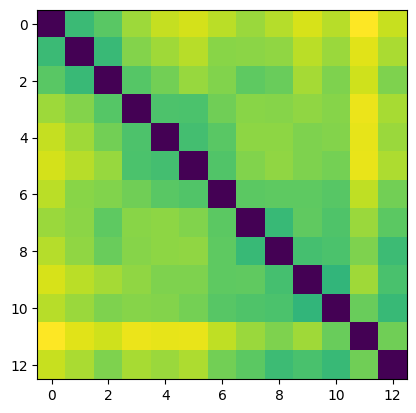

In [224]:
plt.imshow(trial_start_frob)

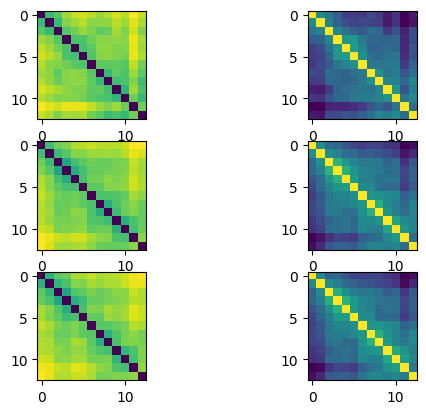

In [226]:
fig, axs = plt.subplots(3,2)
axs[0,0].imshow(trial_start_frob)
axs[0,1].imshow(trial_start_angle)
axs[1,0].imshow(threshold_crossing_frob)
axs[1,1].imshow(threshold_crossing_angle)
axs[2,0].imshow(actVec_frob)
axs[2,1].imshow(actVec_angle)

In [218]:
)

array([[0.99999982, 0.84048909, 0.81405455, 0.78288335, 0.74824697,
        0.74405664, 0.73999363, 0.76470649, 0.74146771, 0.71402293,
        0.73678207, 0.69015408, 0.71246094],
       [0.84048909, 1.00000012, 0.82722497, 0.78973144, 0.76392323,
        0.75354785, 0.76019269, 0.7539776 , 0.74902201, 0.71237755,
        0.73545271, 0.69337428, 0.70658827],
       [0.81405455, 0.82722497, 1.        , 0.83231682, 0.80610508,
        0.78481799, 0.77588254, 0.80405307, 0.7920962 , 0.74244481,
        0.77030128, 0.72074628, 0.76033735],
       [0.78288335, 0.78973144, 0.83231682, 1.        , 0.85156834,
        0.855946  , 0.81463355, 0.79499441, 0.79528701, 0.78953421,
        0.79487008, 0.72410053, 0.76158458],
       [0.74824697, 0.76392323, 0.80610508, 0.85156834, 1.00000012,
        0.86263734, 0.8326692 , 0.78926384, 0.78747678, 0.80129606,
        0.79388118, 0.72577351, 0.77246237],
       [0.74405664, 0.75354785, 0.78481799, 0.855946  , 0.86263734,
        0.99999994, 0.84593

In [155]:
for date in tqdm(F_objs):
    print(Fneu_objs[date].shape)

100%|███████████████████████████████████████| 15/15 [00:00<00:00, 204268.05it/s]

(3019, 108000)
(3164, 108000)
(3343, 108000)
(3347, 108000)
(3172, 108000)
(3301, 108000)
(3266, 108000)
(3215, 108000)
(3133, 108000)
(3095, 108000)
(3200, 108000)
(3196, 108000)
(3186, 108000)
(3198, 108000)
(3177, 108000)


In [43]:
make_dFoF_partial = partial(bnpm.ca2p_preprocessing.make_dFoF, neuropil_fraction=0.7, roll_centered=False, roll_interpolation='nearest', multicore_pref=True)

In [44]:
F_objs['20230502'].shape

(2382, 108000)

In [62]:
outs = {date: make_dFoF_partial(
    F=F, 
    Fneu=Fneu, 
    percentile_baseline=30,
    roll_stride=1,
) for (date,F),(date,Fneu) in zip(F_objs.items(), Fneu_objs.items())}
dFoF, dF, F_neuSub, F_baseline = ({date: o[ii] for date, o in outs.items()} for ii in range(4))

Calculated dFoF. Total elapsed time: 1.14 seconds
Calculated dFoF. Total elapsed time: 1.13 seconds
Calculated dFoF. Total elapsed time: 1.14 seconds
Calculated dFoF. Total elapsed time: 1.2 seconds


In [65]:
for date in dFoF.keys():
    dFoF[date][dFoF[date] > expParams_objs[date]['params']['dFoF']['thresh_violation_dFoF']] = np.nan

In [66]:
for date in dFoF.keys():
    dFoF[date][F_baseline[date] < expParams_objs[date]['params']['dFoF']['thresh_violation_F_baseline']] = np.nan

In [67]:
dFoF_matched = {}
for date,dfof in dFoF.items():
    idx = idx_matching_decoderVector[date]
    arr = dfof[idx]
    arr[idx==-1] = arr[idx==-1] * np.nan
    dFoF_matched.update({date: arr})

In [68]:
dFoF_matched.keys()

dict_keys(['20230502', '20230503', '20230504', '20230505'])

In [69]:
[np.nanmin(v) for v in dFoF_matched.values()]

[-1.5802757, -2.09489, -1.9323068, -4.70738]

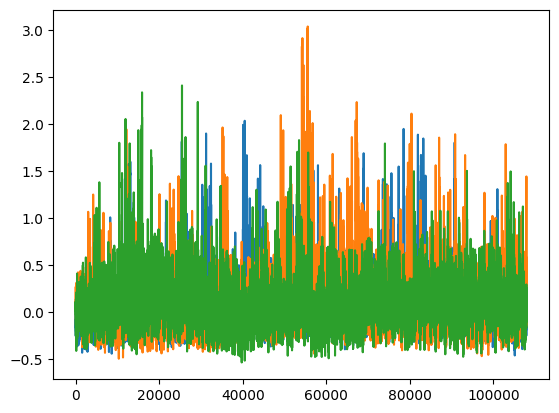

In [49]:
plt.figure()
plt.plot(dFoF_matched['20230502'][45])
plt.plot(dFoF_matched['20230503'][45])
plt.plot(dFoF_matched['20230504'][45])

## netrep analysis

In [54]:
from netrep.metrics import LinearMetric

In [49]:
len(np.nanmean(dFoF_matched['20230503'], axis=0))

108000

In [50]:
np.nanmean(dFoF_matched['20230503'], axis=1).shape

/tmp/ipykernel_50464/1785636710.py:1: RuntimeWarning:

Mean of empty slice



(597,)

In [51]:
dFoF_netrep = [np.nan_to_num(center_mean(dFoF_matched[day].T)) for day in list(dFoF_matched.keys())]

/tmp/ipykernel_4394/3683051905.py:14: RuntimeWarning:

Mean of empty slice



Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matrix shape: (108000, 597)
Subtract matrix shape: (1, 597)
Given matr

In [53]:
def corrcoef(matrix_X, matrix_Y):
    """
    Matrix shape: sample * feature. Each features are mean-centered.
    """
    cov = matrix_X.T @ matrix_Y
    return (cov / np.linalg.norm(matrix_X, axis=0)) / np.linalg.norm(matrix_Y, axis=0)

## Minimize sample permutation effect

In [45]:
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [46]:
def hungarian_perm(ref_matrix, obj_matrix):
    cost_matrix = cdist(ref_matrix, obj_matrix)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return col_ind

In [ ]:
win_bounds = [-30*8, 30*8]

reward_response = []
min_reward = np.inf
for ii, date in enumerate(dates_toUse[1:]):
    dFoF = dFoF_netrep[ii]
    et_traces_end, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
        arr=dFoF.T,
        idx_triggers=trials_111_success[date]['frames_end'],
        win_bounds=win_bounds,
        dim=-1,
    )
    
    
    rate_at_thresh = np.nanmean(et_traces_end[:,:,235:240], axis=2)
    if rate_at_thresh.shape[1] > 50:
        reward_response.append(rate_at_thresh)
#         print(rate_at_thresh.shape[1])
        min_reward = np.min((min_reward, rate_at_thresh.shape[1]))

# reward_response = np.stack(reward_response, axis=0)

In [ ]:
reward_netrep = []
for session in reward_response:
    reward_netrep.append(session.T[:int(min_reward)])

In [ ]:
reward_netrep[0].shape

In [ ]:
reward_netrep_perm = [reward_netrep[0]]
for ii, session in enumerate(reward_netrep[1:]):
    session_perm_idx = hungarian_perm(reward_netrep[ii], session)
    reward_netrep_perm.append(session[session_perm_idx])

In [ ]:
reward_netrep_perm = np.stack(reward_netrep_perm, axis=0)

In [ ]:
reward_proc_metric = LinearMetric(alpha=1.0)
reward_proc_distance, _ = reward_proc_metric.pairwise_distances(reward_netrep_perm)

In [ ]:
plt.figure()
plt.imshow(np.cos(reward_proc_distance), cmap='viridis', clim=(-1,1))

In [ ]:
reward_netrep_pca = []
for dFoF in reward_netrep:
    _, scores, _, _ = bnpm.decomposition.torch_pca(dFoF, rank=5)
    reward_netrep_pca.append(scores)

In [ ]:
reward_netrep_pca_perm = [reward_netrep_pca[0]]
for ii, session in enumerate(reward_netrep_pca[1:]):
    session_perm_idx = hungarian_perm(reward_netrep_pca[ii], session)
    reward_netrep_pca_perm.append(session[session_perm_idx])

In [ ]:
reward_netrep_pca_perm[0].shape

In [ ]:
reward_netrep_pca_perm = np.stack(reward_netrep_pca_perm, axis=0)

In [ ]:
pca_reward_proc_metric = LinearMetric(alpha=1.0)
pca_reward_proc_distance, _ = pca_reward_proc_metric.pairwise_distances(reward_netrep_pca_perm)

In [ ]:
plt.figure()
plt.imshow(np.cos(pca_reward_proc_distance), cmap='viridis', clim=(-1,1))

## Average trials

data matrix per day: (4 * Fs, N) where Fs = 30, N = the number of neurons.

Sampled -2 - 0 sec from trial start / threshold crossing, averaged and concatenated.

In [70]:
win_bounds = [-30*2, 0]

reward_response = []
min_reward = np.inf
for ii, date in enumerate(dates_toUse[1:]):
#     dFoF = dFoF_netrep[ii]
    dFoF = dFoF_matched[date].T
    et_traces_start, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
        arr=dFoF.T,
        idx_triggers=trials_111_success[date]['frames_start'],
        win_bounds=win_bounds,
        dim=-1,
    )
    
    et_traces_end, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
        arr=dFoF.T,
        idx_triggers=trials_111_success[date]['frames_end'],
        win_bounds=win_bounds,
        dim=-1,
    )
    reward_response.append(np.nan_to_num(np.concatenate((np.nanmean(et_traces_start, axis=1), np.nanmean(et_traces_end, axis=1)), axis=1).T))

/home/gyuheo/anaconda3/envs/roicat/lib/python3.11/site-packages/bnpm/timeSeries.py:382: UserWarning:

idx_triggers is np.ndarray but not integer dtype. Converting to torch.long dtype.

/tmp/ipykernel_54120/1005595124.py:21: RuntimeWarning:

Mean of empty slice



In [107]:
dFoF_netrep[0].shape

(108000, 597)

In [118]:
dFoF_netrep[0].mean(0)

array([-1.10202363e-08,  2.79038037e-09,  3.44735618e-08, -1.97799110e-08,
       -6.64039890e-09,  2.54313157e-08,  1.41285084e-09,  1.70248526e-08,
        1.49762194e-08, -2.31707542e-08,  7.34682448e-09,  6.35782893e-09,
        1.80138482e-08,  1.94266985e-08,  6.35782893e-09,  8.81618902e-08,
       -8.47710513e-10,  1.90734872e-09,  2.82570167e-09, -1.58239288e-08,
       -6.81700518e-09, -3.10827186e-09,  1.70954948e-08, -5.22754817e-09,
       -3.39084205e-09, -8.61839045e-09,  3.39084205e-09, -7.77067966e-10,
       -1.27156574e-09, -7.73535813e-09, -5.08626297e-09,  3.42616335e-09,
        8.83031781e-09,  1.79432060e-08, -5.93397331e-09, -6.35782871e-10,
        8.47710524e-09,  2.27822206e-08,  2.82570167e-09, -1.97799110e-09,
        9.88995552e-09,  2.96698666e-09,  1.18679466e-08,  1.10202363e-08,
        1.29982274e-08, -9.46610079e-09, -5.08626297e-09,  1.45523638e-08,
        6.58741683e-09,  1.97799110e-09, -1.02431690e-08, -9.64270708e-09,
        2.93872979e-08, -

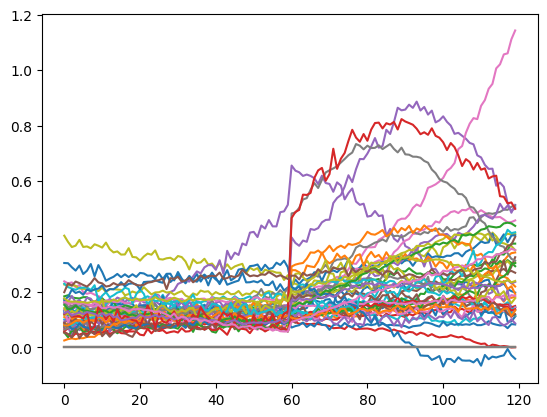

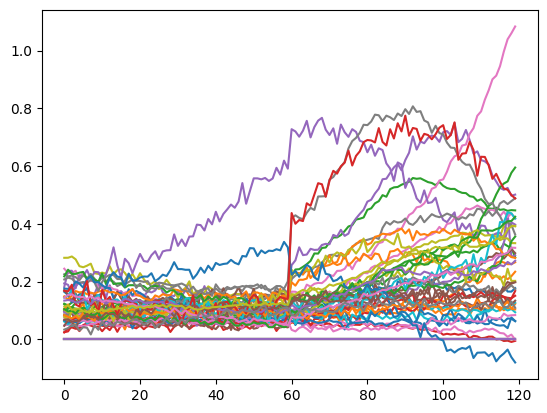

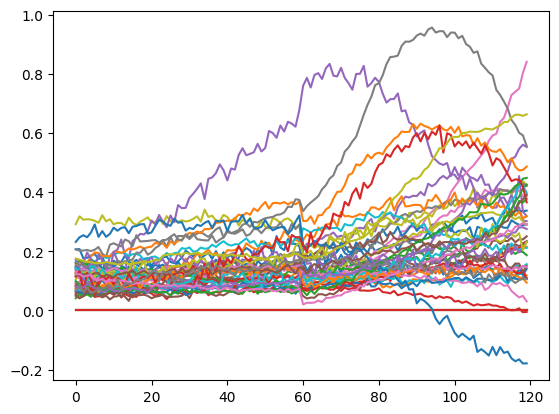

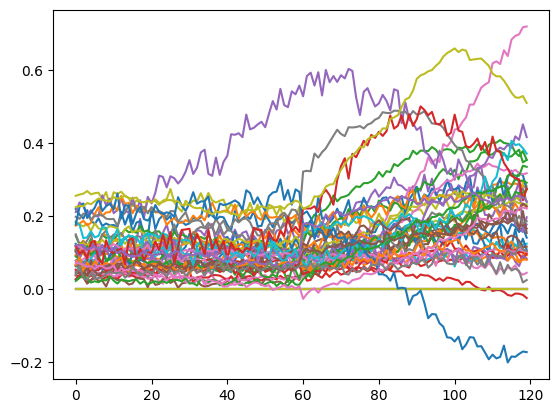

In [155]:
plt.figure()
plt.plot(reward_response[13][:,1:50]);
plt.figure()
plt.plot(reward_response[14][:,1:50]);
plt.figure()
plt.plot(reward_response[15][:,1:50]);
plt.figure()
plt.plot(reward_response[16][:,1:50]);

In [135]:
trial_avg_proc_metric = LinearMetric(alpha=1.0)
trial_avg_proc_distance, _ = trial_avg_proc_metric.pairwise_distances(reward_response)

Parallelizing 136 distance calculations with 16 processes.


Computing distances: 100%|████████████████████| 136/136 [00:15<00:00,  8.98it/s]


In [136]:
trial_avg_fig = plotly_imshow(np.cos(trial_avg_proc_distance))
trial_avg_fig.show()

## CKAs

data matrix per day: (4 * Fs, N) where Fs = 30, N = the number of neurons.

Sampled -2 - 0 sec from trial start / threshold crossing, averaged and concatenated.

In [62]:
from scipy.spatial.distance import pdist, squareform

def linear_kernel(X):
    return np.dot(X, X.T)

def center_kernel(K):
    n_samples = K.shape[0]
    one_n = np.ones((n_samples, n_samples)) / n_samples
    return K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

def compute_cka(X, Y):
    K_x = linear_kernel(X)
    K_y = linear_kernel(Y)
    
    K_xc = center_kernel(K_x)
    K_yc = center_kernel(K_y)

    hsic = np.trace(np.dot(K_xc, K_yc))

    cka_score = hsic / np.sqrt(np.trace(np.dot(K_xc, K_xc)) * np.trace(np.dot(K_yc, K_yc)))
    
    return cka_score

def compute_pairwise_cka(matrices):
    M = len(matrices)
    cka_scores = np.zeros((M, M))
    for i in range(M):
        for j in range(i, M):
            cka_score = compute_cka(matrices[i], matrices[j])
            cka_scores[i, j] = cka_score
            cka_scores[j, i] = cka_score
    return cka_scores

In [137]:
test_cka_scores = compute_pairwise_cka(reward_response)

In [138]:
cka_fig = plotly_imshow(test_cka_scores)
cka_fig.show()

## Cursor-based realignment

data matrix per day: (bins, N) where bins = the number of frequency bins, N = the number of neurons.

Bagged neural response measured at specific frequency window, and averaged within each bin.

In [74]:
cursor_filter = np.linspace(1000, 18000, 35)
dFoF_frequency_aligned = []
control = True

for date in logger_dfs.keys():
    
    ## Extract online feedback frequency
    cursor_freq = logger_dfs[date]['decoder']['freqToOutput'].to_numpy()
    CE_trial = logger_dfs[date]['timeSeries']['CE_trial'].to_numpy()
    real_feedback = np.logical_not(logger_dfs[date]['timeSeries']['fakeFeedback_inUse'].to_numpy())
    
    if control:
        feedback_cursor_freq = np.nan_to_num(cursor_freq * CE_trial)
    else:
        feedback_cursor_freq = np.nan_to_num(cursor_freq * CE_trial * real_feedback)
    
    ## Sample real feedbacks only
    feedback_cursor_freq_idx = feedback_cursor_freq > 0
    feedback_cursor_freq = feedback_cursor_freq[feedback_cursor_freq_idx]
    
    ## Match dFoF timeseries
    dFoF_real_feedback = np.nan_to_num(dFoF_matched[date][:, feedback_cursor_freq_idx])
    
    ## Find which frequency bin is each timepoint in
    bin_index = np.digitize(feedback_cursor_freq, cursor_filter)
    
    ## Bag and average neural response to a specific frequency bin    
    dFoF_frequency_matched = [np.nan_to_num(np.nanmean(dFoF_real_feedback[:,bin_index == ii], axis=1)) for ii in range(len(cursor_filter))]
    dFoF_frequency_aligned.append(np.stack(dFoF_frequency_matched))

/tmp/ipykernel_6434/4094946756.py:28: RuntimeWarning:

Mean of empty slice



In [75]:
dFoF_frequency_aligned[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.39058265, 0.16500539, 0.15509667, ..., 0.10645606, 0.15066215,
        0.11775245],
       [0.45191056, 0.17509113, 0.17802367, ..., 0.08549117, 0.14673084,
        0.11753305],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [76]:
frequency_proc_metric = LinearMetric(alpha=1.0)
frequency_proc_distance, _ = frequency_proc_metric.pairwise_distances(dFoF_frequency_aligned[1:])

Parallelizing 136 distance calculations with 16 processes.


Computing distances: 100%|████████████████████| 136/136 [00:12<00:00, 10.60it/s]


In [77]:
frequency_proc_distance

array([[0.        , 0.4576703 , 0.46496304, 0.51376859, 0.51852717,
        0.47675184, 0.59429078, 0.49272391, 0.52596211, 0.49159339,
        0.48350202, 0.71749334, 0.48019051, 0.49419349, 0.45643079,
        0.49696712, 0.50058771],
       [0.4576703 , 0.        , 0.17343824, 0.2896816 , 0.30651855,
        0.17829645, 0.37375317, 0.48800003, 0.29021609, 0.21781091,
        0.22109756, 0.83827256, 0.16642645, 0.20428786, 0.1808907 ,
        0.20343038, 0.18978063],
       [0.46496304, 0.17343824, 0.        , 0.30804673, 0.29725048,
        0.19163367, 0.36484052, 0.49551339, 0.29304524, 0.2079635 ,
        0.2219956 , 0.87253549, 0.18033616, 0.16490817, 0.16939143,
        0.22358869, 0.16144746],
       [0.51376859, 0.2896816 , 0.30804673, 0.        , 0.40908827,
        0.33464514, 0.2676904 , 0.55066304, 0.18972861, 0.35259808,
        0.35013925, 0.8645029 , 0.29600922, 0.33412174, 0.30259879,
        0.31468129, 0.3322626 ],
       [0.51852717, 0.30651855, 0.29725048, 0.409088

In [80]:
freq_fig = plotly_imshow(np.cos(frequency_proc_distance), zmin=0.7, zmax=1)
freq_fig.show()

## Simple error matrix

In [156]:
reward_response[0].shape

(120, 597)

In [198]:
def trace_drift(session_1, session_2, p=2):
    """
    session_1 and session_2: T * N where T is the number of samples and N is the number of neurons
    """
    return np.mean(np.mean(np.abs(session_1 - session_2)**p, axis=1), axis=0)

In [61]:
def trace_drift(session_1, session_2, p=2):
    """
    session_1 and session_2: T * N where T is the number of samples and N is the number of neurons
    """
    return np.mean((np.mean(np.abs(session_1 - session_2), axis=1) / np.mean(np.abs(session_1), axis=1))**p, axis=0)

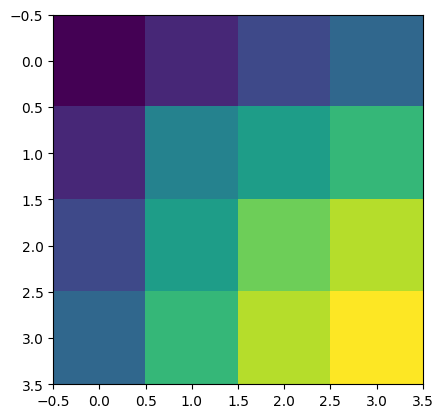

In [76]:
test = np.linspace(0,1,10)
plt.figure()
plt.imshow(fill_symmetric(test))

In [62]:
pairwise_error_distance = []
for ii, session in enumerate(reward_response):
#     print(ii)
    for jj in range(len(reward_response) - ii):
#         print(ii + jj)
        distance = trace_drift(session, reward_response[ii + jj], p=1)
        pairwise_error_distance.append(distance)
        
pairwise_error_matrix = fill_symmetric(pairwise_error_distance)

In [63]:
pairwise_error_figure = plotly_imshow(pairwise_error_matrix, cmap='Viridis_r')
pairwise_error_figure.show()

In [168]:
tester

array([[0.        , 0.11111111, 0.22222222, 0.33333333],
       [0.11111111, 0.44444444, 0.55555556, 0.66666667],
       [0.22222222, 0.55555556, 0.77777778, 0.88888889],
       [0.33333333, 0.66666667, 0.88888889, 1.        ]])

In [ ]:
U S V.T U, V orthonormal, S diagonal.
U V f * f (n * n)

netrep(X, Y) -> U, V => X @ U, Y @ V <= optimally aligned.

X_opt = X @ U @ V.T => Y
<X, X_opt> + <Y, Y_opt>


## Compare transformation (rotation) matrix: Error norm (fro)

Analysis: simple element-wise L2 norm of the difference between original matrix and optimally rotated matrix.

(m, n) elements of the similarity matrix:
1. Find the rotation matrix Rm that optimally aligns matrix M to matrix N. Rm minimizes |M @ Rm - N|. Calculate Frobenius norm of (M - M @ Rm) = error_norm(M)
2. Find the rotation matrix Rn that optimally aligns matrix N to matrix M. Rn minimizes |M - N @ Rn|.Calculate Frobenius norm of (N - N @ Rn) = error_norm(N)
3. Add error_norm(M) and error_norm(N)

In [89]:
frobenius_error_norm = []
for ii, session in enumerate(reward_response):
    for jj in range(len(reward_response) - ii):
        test_proc_metric = LinearMetric(alpha=1.0)
        test_proc_metric.fit(session, reward_response[ii + jj])
        
        best_rotation = test_proc_metric.Wx_ @ test_proc_metric.Wy_.T
        session_ms = session - test_proc_metric.mx_[None,:]
        Y_ms = reward_response[ii + jj] - test_proc_metric.my_[None,:]
        
        X_L2_norm = np.linalg.norm(session_ms - session_ms @ best_rotation)
        Y_L2_norm = np.linalg.norm(Y_ms - Y_ms @ best_rotation.T)
        
        frobenius_error_norm.append(X_L2_norm + Y_L2_norm)

[autoreload of analysis_pipeline.analysis_pipeline.drift_analysis.drifter failed: Traceback (most recent call last):
  File "/home/gyuheo/anaconda3/envs/roicat/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/gyuheo/anaconda3/envs/roicat/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/gyuheo/anaconda3/envs/roicat/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/media/gyuheo/sto

In [91]:
help(test_proc_metric)

Help on LinearMetric in module netrep.metrics.linear object:

class LinearMetric(sklearn.base.BaseEstimator)
 |  LinearMetric(alpha: 'float' = 1.0, center_columns: 'bool' = True, zero_pad: 'bool' = True, score_method: "Literal['angular', 'euclidean']" = 'angular')
 |  
 |  Computes distance between two sets of optimally linearly aligned representations.
 |  
 |  Method resolution order:
 |      LinearMetric
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, alpha: 'float' = 1.0, center_columns: 'bool' = True, zero_pad: 'bool' = True, score_method: "Literal['angular', 'euclidean']" = 'angular')
 |      Parameters
 |      ----------
 |      alpha : float
 |          Regularization parameter between zero and one. When
 |          (alpha == 1.0) the metric only allows for rotational
 |          alignments. When (alpha == 0.0) the metric allows for
 |          any invertible linear transformation.
 |      
 |      center_columns

In [93]:
test_proc_metric.__dict__.keys()

dict_keys(['alpha', 'center_columns', 'zero_pad', 'score_method', 'mx_', 'my_', 'Wx_', 'Wy_'])

In [96]:
test = np.var(reward_response[0], axis=0) / np.sum(np.var(reward_response[0], axis=0))

In [100]:
reward_response[0] * test

array([[3.13791388e-04, 1.19708781e-03, 1.00592166e-04, ...,
        3.68625770e-05, 1.36634108e-05, 1.80525840e-05],
       [3.00035201e-04, 9.60363890e-04, 7.66834783e-05, ...,
        3.65977940e-05, 1.63324348e-05, 1.08602680e-05],
       [2.83614587e-04, 8.05889256e-04, 1.16406532e-04, ...,
        4.54500951e-05, 1.77885540e-05, 1.57973755e-05],
       ...,
       [3.51859344e-04, 3.46580334e-03, 5.41628106e-04, ...,
        6.22992520e-05, 2.54239440e-05, 5.20087342e-05],
       [3.54318385e-04, 3.39646614e-03, 4.79086273e-04, ...,
        5.62448877e-05, 2.17495162e-05, 4.37827148e-05],
       [3.66998895e-04, 3.20560252e-03, 4.85427852e-04, ...,
        4.28857966e-05, 1.05170020e-05, 5.97269027e-05]], dtype=float32)

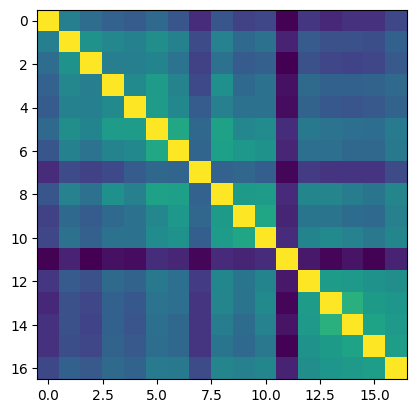

In [54]:
frobenius_error_matrix = fill_symmetric(frobenius_error_norm)
plt.figure()
plt.imshow(frobenius_error_matrix, cmap='viridis_r')

In [60]:
frobenius_error_figure = plotly_imshow(frobenius_error_matrix, cmap='Viridis_r')
frobenius_error_figure.show()

In [131]:
frobenius_sanity = []
for ii, session in enumerate(reward_response):
    for jj in range(len(reward_response) - ii):
        test_proc_metric = LinearMetric(alpha=1.0)
        test_proc_metric.fit(session, reward_response[ii + jj])
        
        best_rotation = test_proc_metric.Wx_ @ test_proc_metric.Wy_.T
        session_ms = session - test_proc_metric.mx_[None,:]
        Y_ms = reward_response[ii + jj] - test_proc_metric.my_[None,:]
        
        sanity_norm = np.linalg.norm(session_ms @ best_rotation - Y_ms)
        
        frobenius_sanity.append(sanity_norm)

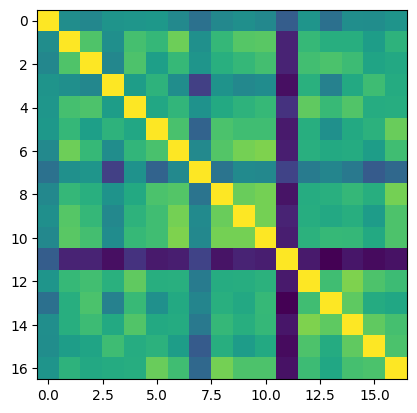

In [132]:
frobenius_sanity_matrix = fill_symmetric(frobenius_sanity)
plt.figure()
plt.imshow(frobenius_sanity_matrix, cmap='viridis_r')

In [133]:
frobenius_error_figure = plotly_imshow(frobenius_sanity_matrix, cmap='Viridis_r')
frobenius_error_figure.show()

## Compare transformation (rotation) matrix: angle-wise

Analysis: average column-wise (factor-wise) cosine similarity across original matrix and optimally transformed matrix.

(m, n) elements of the similarity matrix:
1. Find the rotation matrix Rm that optimally aligns matrix M to matrix N. Calculate average column-wise cosine similarity between (M, M @ Rm) = angle(M)
2. Find the rotation matrix Rn that optimally aligns matrix N to matrix M. Calculate average column-wise cosine similarity between (N, N @ Rn) = angle(N)
3. Average angle(M) and angle(N)

In [117]:
def compute_average_angle(X1, X2, mean_center = False, verbose = False):
    """
    X1, X2 shapes T * N matrices, where T is the number of sample and N is the number of neurons.
    
    args:
        X1, X2 (np.ndarray): num.sample * num.feature shape matrix.
        mean_center (bool): If True, apply mean-centering transformation
    
    Return:
        angles_mean (float): average angular difference between features. [0, np.pi]
    """
    if mean_center:
        X1 = center_mean(X1, verbose=verbose)
        X2 = center_mean(X2, verbose=verbose)

    cossim = np.sum((X1 * X2) / (np.linalg.norm(X1, axis=1, keepdims=True) * np.linalg.norm(X2, axis=1, keepdims=True)), axis=0)

    ## Change to angle (metric space) and take the mean of angles
    cossim = np.clip(cossim, -1, 1) # This line is necessary to prevent error
    angles = np.arccos(cossim)
    angles_mean = np.mean(angles)
    
    ## Return the average angle
    return angles_mean
#     return angles

In [118]:
pairwise_angles = []
for ii, session in enumerate(reward_response):
    for jj in range(len(reward_response) - ii):
        test_proc_metric = LinearMetric(alpha=1.0)
        test_proc_metric.fit(session, reward_response[ii + jj])
        
        best_rotation = test_proc_metric.Wx_ @ test_proc_metric.Wy_.T
        session_ms = session - test_proc_metric.mx_[None,:]
        Y_ms = reward_response[ii + jj] - test_proc_metric.my_[None,:]
        
        X_angle = compute_average_angle(session_ms, session_ms @ best_rotation)
        Y_angle = compute_average_angle(Y_ms, Y_ms @ best_rotation.T)
        
#         X_angle = np.clip(X_angle, 0, np.pi)
#         Y_angle = np.clip(X_angle, 0, np.pi)
# #         mean_angle = X_angle + Y_angle
        
        mean_angle = np.clip((X_angle + Y_angle) / 2, 0, np.pi)
        
        pairwise_angles.append(mean_angle)

In [128]:
pairwise_angles_matrix = fill_symmetric(pairwise_angles)

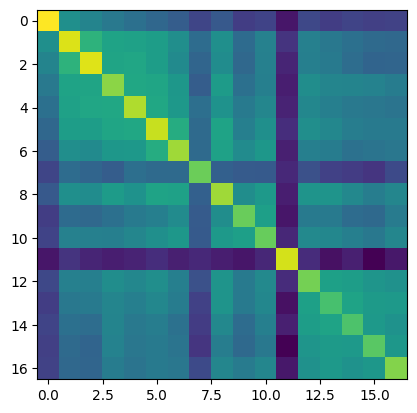

In [129]:
plt.figure()
plt.imshow(np.cos(pairwise_angles_matrix))